In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
%matplotlib inline

In [2]:
# Retreive all the data from the meta-data file
meta_data = ascii.read('../datared/J0600_meta-data.txt')

# To get nice plots, all the data is sorted by the epoch
epoch_tmp = np.array(meta_data["EPOCH"])
sort = np.argsort(epoch_tmp)
epoch_arr = epoch_tmp[sort]

filters = np.array(meta_data["FILTER"])[sort] # Filters of all the .fits images
airmass_arr = np.array(meta_data["AIRMASS"])[sort] # Airmasses for all the .fits images

fits_name_arr = np.array(meta_data["IMAGE"])[sort] # Name of the original .fits file
files_arr = np.array(meta_data["NEWIMG"])[sort] # Name of the data reduced files

N_files = len(epoch_arr) #nr of files
N_stars = len(ascii.read(files_arr[0])["STARNR"]) #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 1762
Number of stars = 161


In [3]:
# Make a mask for all the filters:
filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in filt:
        filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)
print (NimgINf)

fmask = {}
for f in filt:
    fmask[f] = filters == f

    
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars))
fluxerr_tmp = np.zeros((N_files,N_stars))

for i in range(N_files):
    file = files_arr[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = np.array(filecontent["FLUX"])
    fluxerr_tmp[i] = np.array(filecontent["FLUXERR"])

print (np.shape(flux_tmp))
print (np.shape(fluxerr_tmp))


# Make a dictionary where flux[filter] gives an array with all the data for that filter
# And do the same for epoch, airmass, fits_name and files
flux = {}
fluxerr = {}

epoch = {}
airmass = {}
fits_name = {}
files = {}

for f in filt:
    flux[f] = flux_tmp[fmask[f]]
    fluxerr[f] = fluxerr_tmp[fmask[f]]
    
    epoch[f] = epoch_arr[fmask[f]]
    airmass[f] = airmass_arr[fmask[f]]
    fits_name[f] = fits_name_arr[fmask[f]]
    files[f] = files_arr[fmask[f]]


['gp', 'I', 'V', 'B', 'ip', 'up', 'rp']
{'gp': 769, 'I': 1, 'V': 1, 'B': 1, 'ip': 630, 'up': 36, 'rp': 324}
(1762, 161)
(1762, 161)


In [4]:
# I want to exclude the I, V, B and 'up' filter so I do that here:
filt = ['gp', 'ip', 'rp']

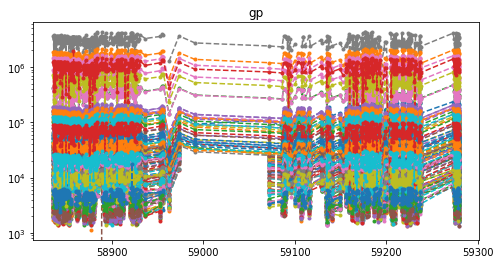

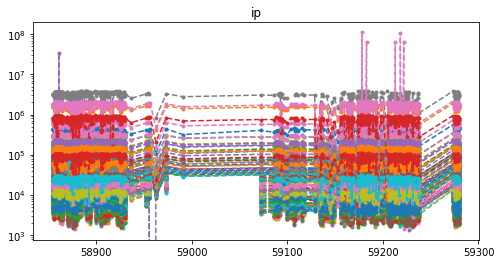

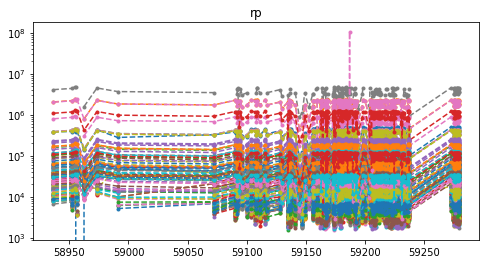

In [5]:
# Testing what the data looks like

# plotting all the flux against epoch for different filters
for f in filt:
    plt.figure(figsize=(8,4))
    #for i in range(N_stars):
    plt.plot(epoch[f],flux[f],linestyle='dashed',marker='.')# label="Star "+str(j), yerr=fluxerr[f] ,fmt='--.')
    plt.title(f)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

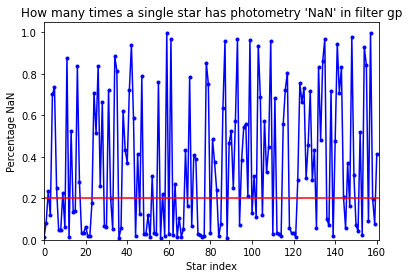

Number of included stars for filter gp = 70/161 (43.5%)


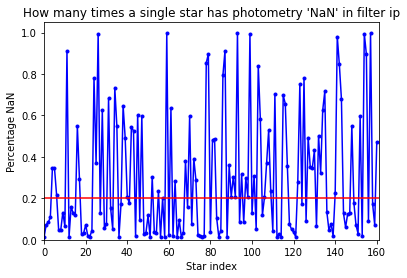

Number of included stars for filter ip = 84/161 (52.2%)


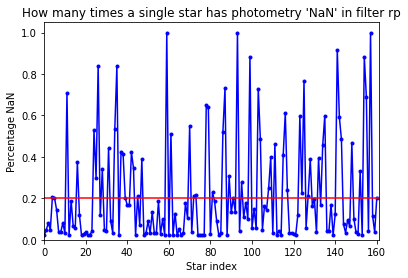

Number of included stars for filter rp = 103/161 (64.0%)


In [6]:
# Make a mask to filter bad stars
maxp_NaN_s = .2 # maximum percentage of NaN's across all filters before it is excluded ##MAKE THIS FILTER SPECIFIC?
star_nan = {} # number of 'NaN' for each star in certain filter
smask = {} # mask of stars included after selection in certain filter
corN_stars = {} # amount of stars included after selection in certain filter
for f in filt:
    star_nan[f] = np.sum(np.isnan(flux[f]),axis=0) 
    smask[f] = star_nan[f]/NimgINf[f] <= maxp_NaN_s
    corN_stars[f] = np.sum(smask[f])

# Plotting the amount of NaN per star, if below red line -> star is included
for f in filt:
    plt.plot(star_nan[f]/NimgINf[f],marker='.', c='b')
    plt.plot([0,N_stars],[maxp_NaN_s,maxp_NaN_s],c='r')
    plt.axis(xmin=-.01,ymin=0,xmax=N_stars+.01)
    plt.title("How many times a single star has photometry 'NaN' in filter "+f)
    plt.xlabel("Star index")
    plt.ylabel("Percentage NaN")
    plt.show()

    print ("Number of included stars for filter {} = {}/{} ({:.1f}%)"\
           .format(f,corN_stars[f],N_stars,100*corN_stars[f]/N_stars))


In [7]:
# Simplifying the masks so combining the filter & photometry mask
flux_excls = {}
fluxerr_excls = {}
for f in filt:
    tmp1 = []
    tmp2 = []
    for i in range(NimgINf[f]):
        tmp1.append(flux[f][i][smask[f]])
        tmp2.append(fluxerr[f][i][smask[f]])
    flux_excls[f] = np.array(tmp1)
    fluxerr_excls[f] = np.array(tmp2)

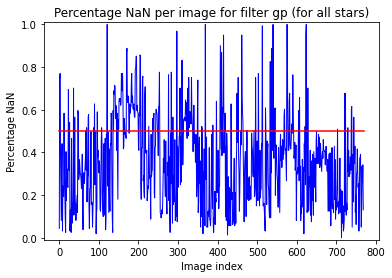

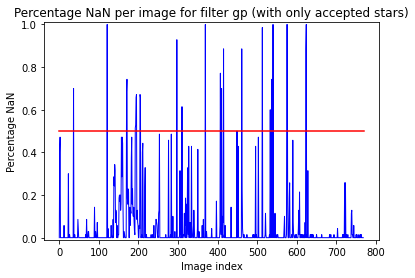

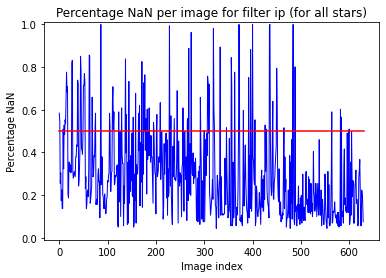

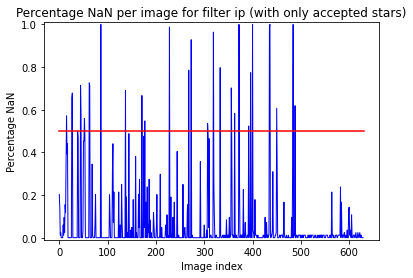

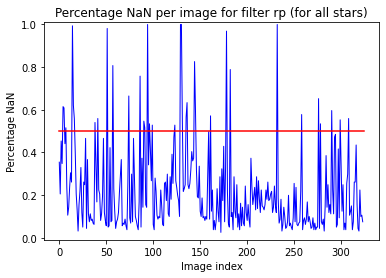

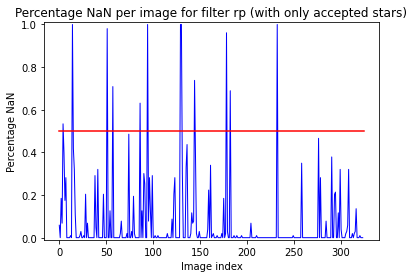

Nr of included images in filter gp = 744/769 (96.7%)
Nr of included images in filter ip = 601/630 (95.4%)
Nr of included images in filter rp = 312/324 (96.3%)


In [8]:
#Make a mask to filter bad photometry
maxp_NaN_e = .5 #maximum percentage of NaN before file is excluded
epoch_NaN = {}
emask = {}
for f in filt:
    tmp = np.sum(np.isnan(flux_excls[f]),axis=1)/corN_stars[f]
    epoch_NaN[f] = tmp
    emask[f] = tmp <= maxp_NaN_e

for f in filt:
    plt.plot(np.sum(np.isnan(flux[f]),axis=1)/N_stars,c='b',linewidth=1)
    plt.plot([0,len(epoch_NaN[f])],[maxp_NaN_e,maxp_NaN_e], c='r')
    plt.title("Percentage NaN per image for filter "+f+" (for all stars)")
    plt.ylabel("Percentage NaN")
    plt.xlabel("Image index") 
    plt.axis(ymin=-.01,ymax=1.01)
    plt.show()
    plt.plot(epoch_NaN[f],c='b',linewidth=1)
    plt.plot([0,len(epoch_NaN[f])],[maxp_NaN_e,maxp_NaN_e], c='r')
    plt.title("Percentage NaN per image for filter "+f+" (with only accepted stars)")
    plt.ylabel("Percentage NaN")
    plt.xlabel("Image index") 
    plt.axis(ymin=-.01,ymax=1.01)
    plt.show()

for f in filt:
    print ("Nr of included images in filter {} = {}/{} ({:.1f}%)"\
           .format(f, np.sum(emask[f]), len(emask[f]), 100*float(np.sum(emask[f]))/float(len(emask[f]))))

In [9]:
# Simplifying the masks so combining the filter & photometry mask
corflux = {}
corfluxerr = {}
corairmass = {}
corfits_name = {}
corfiles = {}
corepoch = {} # make a corrected epoch where the bad photometry is excluded
for f in filt:
    corflux[f] = flux_excls[f][emask[f]]
    corfluxerr[f] = fluxerr_excls[f][emask[f]]
    corairmass[f] = airmass[f][emask[f]]
    corfits_name[f] = fits_name[f][emask[f]]
    corfiles[f] = files[f][emask[f]]
    corepoch[f] = epoch[f][emask[f]]

# Making a mask for the stars without any NaN in their data after exclusion of bad fotometry images
star_withoutnan = {}
print ("Nr of stars without NaN after exclusion bad stars & bad photometry: = {}/{}")
for f in filt:
    star_withoutnan[f] = np.sum(np.isnan(corflux[f]), axis=0) == 0
    print ("Filter {} = {}/{} ({:.1f}%)".format(f,np.sum(star_withoutnan[f]),corN_stars[f],\
                                            100*np.sum(star_withoutnan[f])/corN_stars[f]))

Nr of stars without NaN after exclusion bad stars & bad photometry: = {}/{}
Filter gp = 13/70 (18.6%)
Filter ip = 28/84 (33.3%)
Filter rp = 42/103 (40.8%)


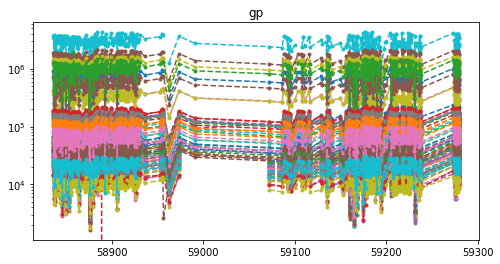

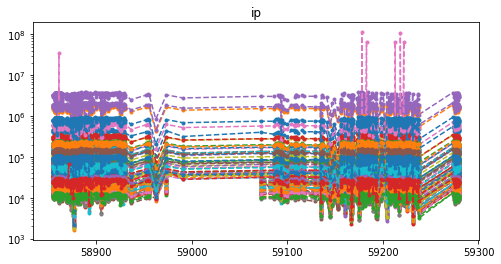

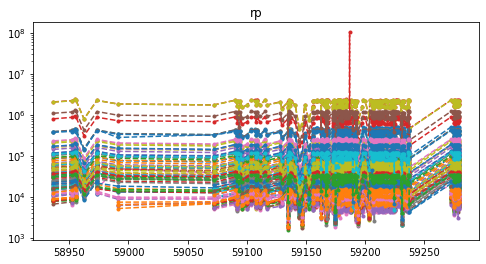

In [10]:
#plotting the flux against epoch for different filters with bad photometry files removed

for f in filt:
    plt.figure(figsize=(8,4))
    #for i in range(N_stars):
    plt.plot(corepoch[f],corflux[f],linestyle='dashed',marker='.')# label="Star "+str(j), yerr=fluxerr[f] ,fmt='--.')
    plt.title(f)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

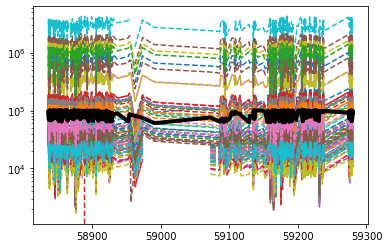

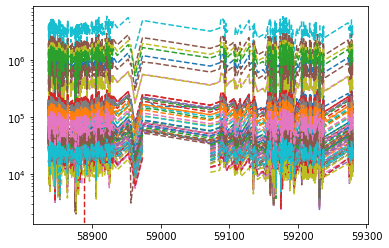

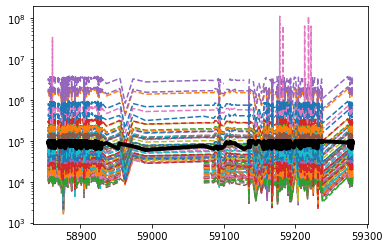

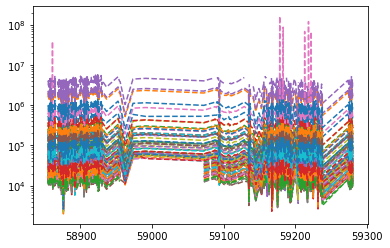

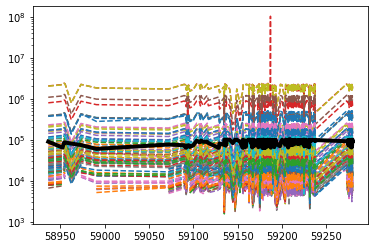

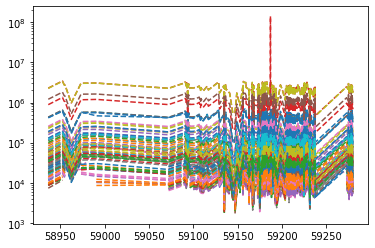

In [11]:
# In this cell I plot the airmass inbetween all the fluxes and then I plot the flux mulitplied by the airmass
#  This does kind of make sense, but the observed flux is also influenced by other things than airmass
#  (e.g. integration time). According to the 
for f in filt:
    plt.plot(corepoch[f],corflux[f],linestyle='dashed')
    plt.plot(corepoch[f], 1/corairmass[f]*1e5,linewidth=4,c='black')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()
    for i in range(corN_stars[f]):
        plt.plot(corepoch[f],corflux[f][:,i]*corairmass[f],linestyle='dashed')
    #plt.plot(epoch[fmask[j]][pmask[j]], 1/airmass[fmask[j]][pmask[j]]*1e5,linewidth=4,c='black')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

In [12]:
# apparently there are some datafiles where the flux & fluxerr is 0.0 ....
for f in filt:
    for e in range(len(corepoch[f])):
        for s in range(corN_stars[f]):
            if corfluxerr[f][e,s] ==0:
                print (corfiles[f][e])
                print (f,e,s,corfluxerr[f][e,s])


../datared/58888.85099_gp.txt
gp 321 33 0.0


In [13]:
#I want to plot the normalised flux so I first want to devide the flux of all stars by their own mean.
# Decided to do it all with weighted mean

# Calculate the weighted mean flux for each star & the error in this weighted mean
meanflux_star = {}
meanfluxerr_star = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(corN_stars[f]):
        nonNaN = np.isnan(corflux[f][:,i]) == False #exclude non NaN datapoints from calculation
        nonNaN *= np.isnan(corfluxerr[f][:,i]) == False
        if np.sum(nonNaN) != 0:
            weight = (1/corfluxerr[f][:,i][nonNaN])**2
            mfluxstar = np.sum(corflux[f][:,i][nonNaN]*weight)/np.sum(weight)
            tmp.append(mfluxstar)
            tmp2.append(1/np.sum(weight))
        else:
            print ("meanflux_star: Filter {} and star {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    plt.show()
    meanflux_star[f] = np.array(tmp)
    meanfluxerr_star[f] = np.array(tmp2)
    #print (meanflux_star)

print ("Amount of NaN values in meanflux(err)_star:")
for f in filt:
    print (f,np.sum(np.isnan(meanflux_star[f])))
    print (f,np.sum(np.isnan(meanfluxerr_star[f])))

#Then I want to devide the fluxes of all stars at one epoch by the normalised mean of all stars at that epoch.
# If the stars are all constant, it should result in a straight line.

# Calculate the weighted mean normalised flux for each epoch & the rror in this weighted mean normalised flux
normfac_epoch = {}
normfacerr_epoch = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(len(corepoch[f])):
        #Exclude the NaN's for the mean
        nonNaN = np.isnan(corflux[f][i]) == False
        nonNaN *= np.isnan(meanflux_star[f])== False #sometimes 
        #print (f,np.sum(nonNaN), np.sum(nonNaN==False))
        if np.sum(nonNaN) != 0:
            mfluxep = (corflux[f][i][nonNaN]/meanflux_star[f][nonNaN])
            mfluxerrep = np.sqrt((corfluxerr[f][i]/meanflux_star[f])**2 +\
                                 (corflux[f][i]*meanfluxerr_star[f]/(meanflux_star[f]**2))**2)[nonNaN]
            weight = 1/mfluxerrep**2
            tmp.append(np.sum(weight*mfluxep)/np.sum(weight))
            tmp2.append(np.sum(weight))
        else:
            print ("normfac_epoch: Filter {} and epoch {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    normfac_epoch[f] = np.array(tmp)
    normfacerr_epoch[f] = np.array(tmp2)


print ("Amount of NaN values in normfac(err)_epoch:")
for f in filt:
    print (f,np.sum(np.isnan(normfac_epoch[f])))
    print (f,np.sum(np.isnan(normfacerr_epoch[f])))

####### STILL HAVE TO EXCLUDE THE NAN UNITS HERE, UPTO THIS POINT EVERYTHING KIND OF WORKS
# Calculate the flux of each star, corrected by the normalised mean flux at a certain epoch
normflux = {}
normfluxerr = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(corN_stars[f]):
        nflux = corflux[f][:,i]/normfac_epoch[f]
        nfluxerr = np.sqrt((corfluxerr[f][:,i]/normfac_epoch[f])**2 + \
                           (corflux[f][:,i]*normfacerr_epoch[f]/(normfac_epoch[f]**2))**2)
        tmp.append(nflux)
        tmp2.append(nfluxerr)
    normflux[f] = np.array(tmp).transpose()
    normfluxerr[f] = np.array(tmp2).transpose()
    #print (normflux[f])

print ("Amount of NaN values in normflux(err):")
for f in filt:
    print (f,np.sum(np.isnan(normflux[f])), "vs", np.sum(np.isnan(corflux[f])))
    print (f,np.sum(np.isnan(normfluxerr[f])), "vs", np.sum(np.isnan(corfluxerr[f])))


#Calculate the flux of each star, correct by the normalised mean flux at a certain epoch, devided by their own mean
# (so the double normalised flux)



Amount of NaN values in meanflux(err)_star:
gp 1
gp 0
ip 0
ip 0
rp 0
rp 0
Amount of NaN values in normfac(err)_epoch:
gp 0
gp 0
ip 0
ip 0
rp 0
rp 0
Amount of NaN values in normflux(err):
gp 1674 vs 1674
gp 1674 vs 1674
ip 1701 vs 1701
ip 1701 vs 1701
rp 1247 vs 1247
rp 1247 vs 1247


<ipython-input-13-0496f7b1da01>:14: RuntimeWarning: divide by zero encountered in true_divide
  weight = (1/corfluxerr[f][:,i][nonNaN])**2
<ipython-input-13-0496f7b1da01>:15: RuntimeWarning: invalid value encountered in multiply
  mfluxstar = np.sum(corflux[f][:,i][nonNaN]*weight)/np.sum(weight)


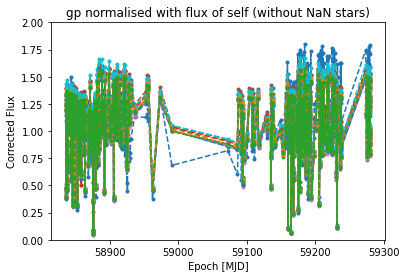

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


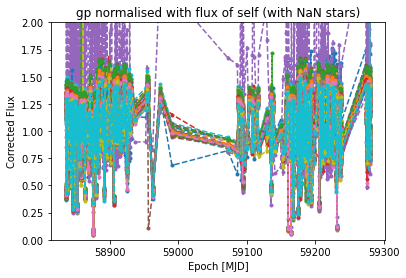

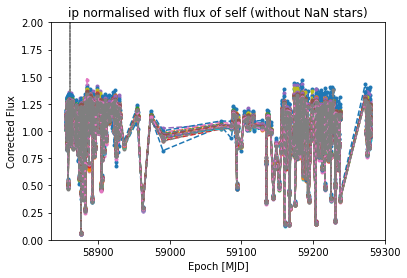

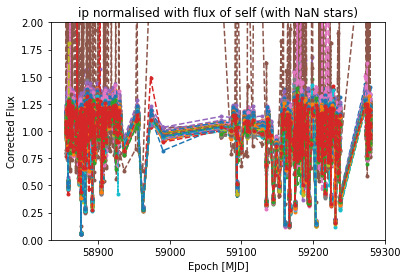

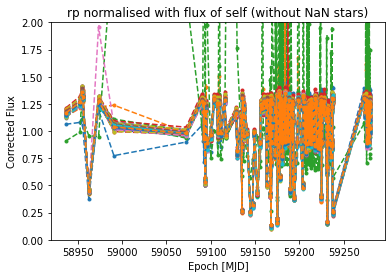

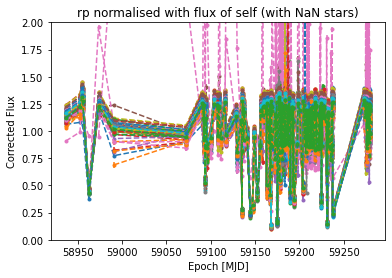

In [14]:
#Plot the flux of all stars normalised with their own flux to check if it worked
for f in filt:
    for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
        plt.errorbar(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],yerr=corfluxerr[f][:,i]/meanflux_star[f][i]\
                     ,fmt='--.',label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised with flux of self (without NaN stars)")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.axis(ymin=0,ymax=2)
    plt.show()
    for i in np.arange(corN_stars[f]):#[star_withoutnan[f]]:
        plt.errorbar(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],yerr=corfluxerr[f][:,i]/meanflux_star[f][i]\
                     ,fmt='--.',label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised with flux of self (with NaN stars)")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.axis(ymin=0,ymax=2)
    plt.show()

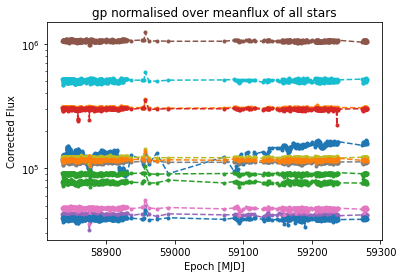

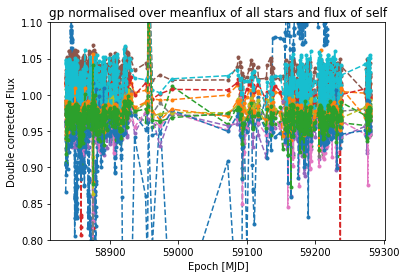

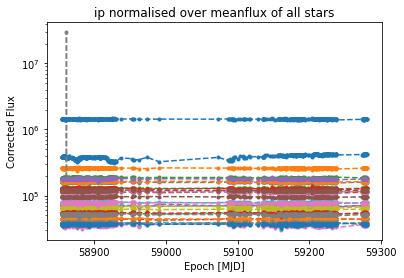

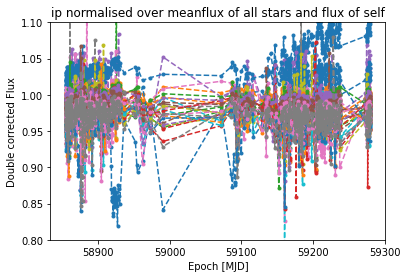

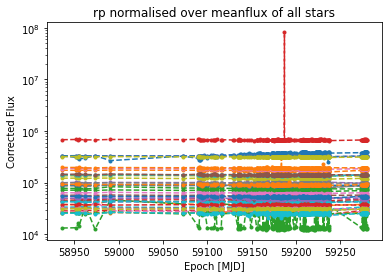

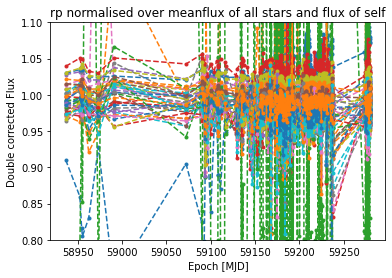

In [15]:
#Plot the epoch-corrected stellar flux.
#Also plot the double corrected plots (which is a straight line for constant stars)
for f in filt:
    for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
        plt.plot(corepoch[f],normflux[f][:,i],linestyle='dashed',marker='.', label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
        plt.plot(corepoch[f],normflux[f][:,i]/meanflux_star[f][i],linestyle='dashed',marker='.', label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    plt.axis(ymin=0.8,ymax=1.1)
    plt.show()

In [16]:
# Making an histogram for the double normalised flux (if star is constant, all values are in same bin)
hist_2nflux = {}
bins_2nflux = {}
N_bins = 19
for f in filt:
    tmp1 = []
    tmp2 = []
    mfsNaN = np.isnan(meanflux_star[f])
    for s in range(corN_stars[f]):
        if mfsNaN[s] == False:
            nonNaN = np.isnan(normflux[f][:,s]) == False
            #print (normflux[f][:,s][nonNaN]/meanflux_star[f][s])
            hist, bins = np.histogram(normflux[f][:,s][nonNaN]/meanflux_star[f][s],bins=N_bins, range=(0.5,1.5))
            tmp1.append(hist)
            tmp2.append(bins)
        else:
            print (f,s,"Will have all NaN values in hist_2nflux")
            tmp1.append([np.NaN]*N_bins)
            tmp2.append([np.NaN]*(N_bins+1))
    hist_2nflux[f] = np.array(tmp1)
    bins_2nflux[f] = np.array(tmp2)

# Calculating the variance in each double normalised flux
varflux_star = {}
for f in filt:
    tmp = []
    mfsNaN = np.isnan(meanflux_star[f])
    for s in range(corN_stars[f]):
        if mfsNaN[s] == False:
            nonNaN = np.isnan(normflux[f][:,s]) == False
            var = np.var(normflux[f][:,s][nonNaN]/meanflux_star[f][s])
            tmp.append(var)
        else:
            print (f,s, "Will have NaN value in varflux_star")
            tmp.append(np.NaN)
    varflux_star[f] = np.array(tmp)
        

gp 33 Will have all NaN values in hist_2nflux
gp 33 Will have NaN value in varflux_star


20
20
20


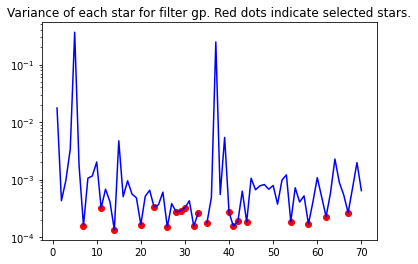

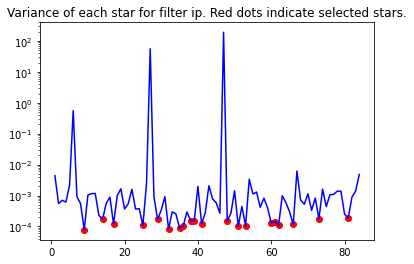

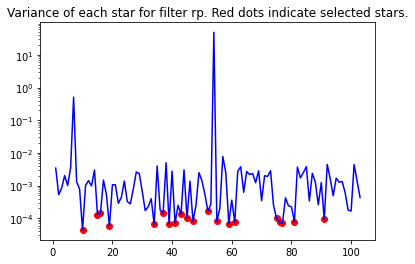

In [17]:
# Selecting the N stars with least variance
var_mask = {}
nr_selected_stars = 20
for f in filt:
    sortindex = np.argsort(varflux_star[f]/np.sum(np.isnan(normflux[f]) == False,axis=0))
    tmp = []
    for s in range(corN_stars[f]):
        tmp.append(varflux_star[f][s] in varflux_star[f][sortindex][:nr_selected_stars])
    var_mask[f] = np.array(tmp)
    print (np.sum(var_mask[f]))
    
for f in filt:
    plt.plot(np.arange(corN_stars[f])+1, varflux_star[f],c='b')
    plt.scatter((np.arange(corN_stars[f])+1)[var_mask[f]], varflux_star[f][var_mask[f]], marker='o',c='r')
    plt.yscale('log')
    plt.title("Variance of each star for filter {}. Red dots indicate selected stars.".format(f))
    plt.show()

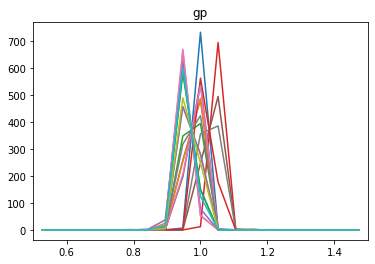

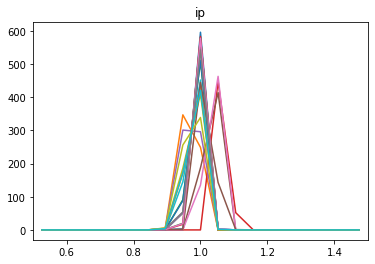

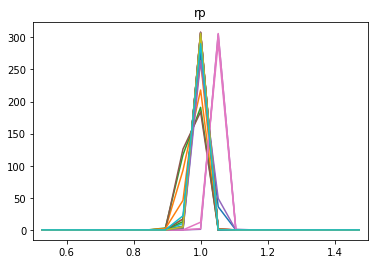

In [18]:
for f in filt:
    for s in np.arange(corN_stars[f])[var_mask[f]]:
        plt.plot((bins_2nflux[f][s][:-1]+bins_2nflux[f][s][1:])/2,hist_2nflux[f][s])
    plt.axis(xmin=0.5,xmax=1.5)
    plt.title(f)#+' '+str(s))
    plt.show()

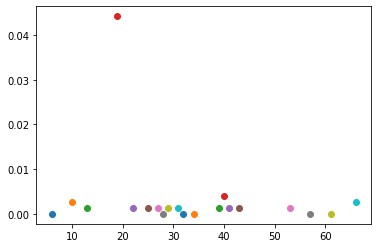

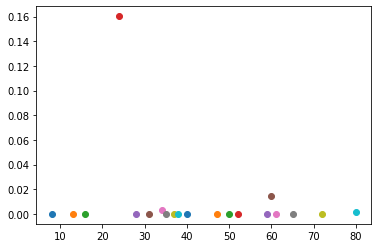

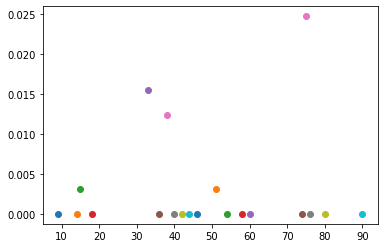

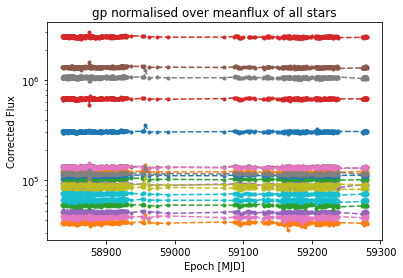

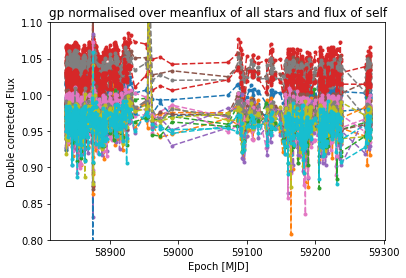

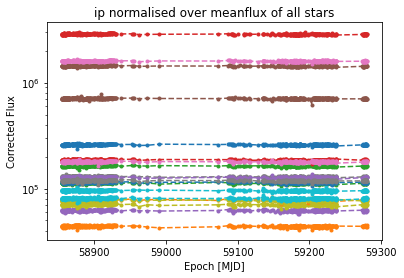

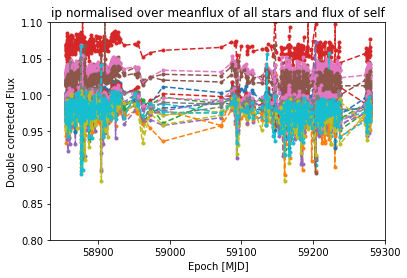

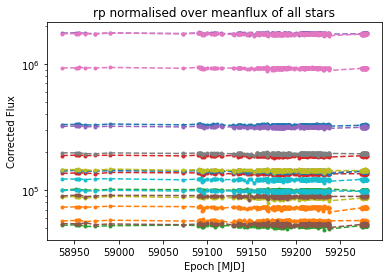

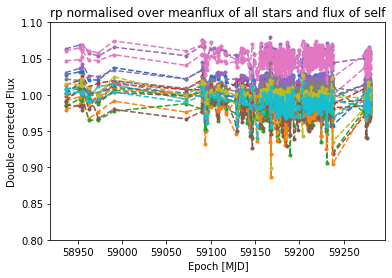

In [19]:
for f in filt:
    #plt.plot(np.sum(np.isnan(normflux[f][var_mask[f]]),axis=1)/NimgINf[f])
    #plt.show()
    for s in np.arange(corN_stars[f])[var_mask[f]]:
        plt.scatter(s, np.sum(np.isnan(normflux[f][:,s]))/NimgINf[f])
    plt.show()

for f in filt:
    for i in np.arange(corN_stars[f])[var_mask[f]]:
        plt.plot(corepoch[f],normflux[f][:,i],linestyle='dashed',marker='.', label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    for i in np.arange(corN_stars[f])[var_mask[f]]:
        plt.plot(corepoch[f],normflux[f][:,i]/meanflux_star[f][i],linestyle='dashed',marker='.', label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    plt.axis(ymin=0.8,ymax=1.1)
    plt.show()

In [20]:
# Again create the double normalisation, but now only using the best of the best stars

# Meanflux star stays the same

# Calculate the weighted mean normalised flux for each epoch & the rror in this weighted mean normalised flux
newnormfac_epoch = {}
newnormfacerr_epoch = {}
for f in filt:
    tmp = []
    for i in range(len(corepoch[f])):
        #Exclude the NaN's for the mean
        nonNaN = np.isnan(corflux[f][i]) == False
        nonNaN *= np.isnan(meanflux_star[f])== False #sometimes 
        mask = nonNaN*var_mask[f]
        #print (f,np.sum(nonNaN), np.sum(nonNaN==False))
        if np.sum(nonNaN) != 0:
            mfluxep = (corflux[f][i][mask]/meanflux_star[f][mask])
            mfluxerrep = np.sqrt((corfluxerr[f][i]/meanflux_star[f])**2 +\
                                 (corflux[f][i]*meanfluxerr_star[f]/(meanflux_star[f]**2))**2)[mask]
            weight = 1/mfluxerrep**2
            tmp.append(np.sum(weight*mfluxep)/np.sum(weight))
            tmp2.append(np.sum(weight))
        else:
            print ("normfac_epoch: Filter {} and epoch {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    newnormfac_epoch[f] = np.array(tmp)
    newnormfacerr_epoch[f] = np.array(tmp2)

print ("Amount of NaN values in normfac(err)_epoch:")
for f in filt:
    print (f,np.sum(np.isnan(normfac_epoch[f])))
    print (f,np.sum(np.isnan(normfacerr_epoch[f])))

####### STILL HAVE TO EXCLUDE THE NAN UNITS HERE, UPTO THIS POINT EVERYTHING KIND OF WORKS
# Calculate the flux of each star, corrected by the normalised mean flux at a certain epoch
newnormflux = {}
#newnormfluxerr = {}
for f in filt:
    tmp = []
    #tmp2 = []
    for i in np.arange(corN_stars[f])[var_mask[f]]:
        nflux = corflux[f][:,i]/newnormfac_epoch[f]
        #nfluxerr = np.sqrt((corfluxerr[f][:,i]/newnormfac_epoch[f])**2 + \
        #                   (corflux[f][:,i]*newnormfacerr_epoch[f]/(normfac_epoch[f]**2))**2)
        tmp.append(nflux)
        #tmp2.append(nfluxerr)
    newnormflux[f] = np.array(tmp).transpose()
    #normfluxerr[f] = np.array(tmp2).transpose()
    #print (normflux[f])

#print ("Amount of NaN values in normflux(err):")
#for f in filt:
#    print (f,np.sum(np.isnan(normflux[f])), "vs", np.sum(np.isnan(corflux[f])))
#    print (f,np.sum(np.isnan(normfluxerr[f])), "vs", np.sum(np.isnan(corfluxerr[f])))


#Calculate the flux of each star, correct by the normalised mean flux at a certain epoch, devided by their own mean
# (so the double normalised flux)


Amount of NaN values in normfac(err)_epoch:
gp 0
gp 0
ip 0
ip 0
rp 0
rp 0


<ipython-input-20-83fd3c1a65f2>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  newnormfacerr_epoch[f] = np.array(tmp2)


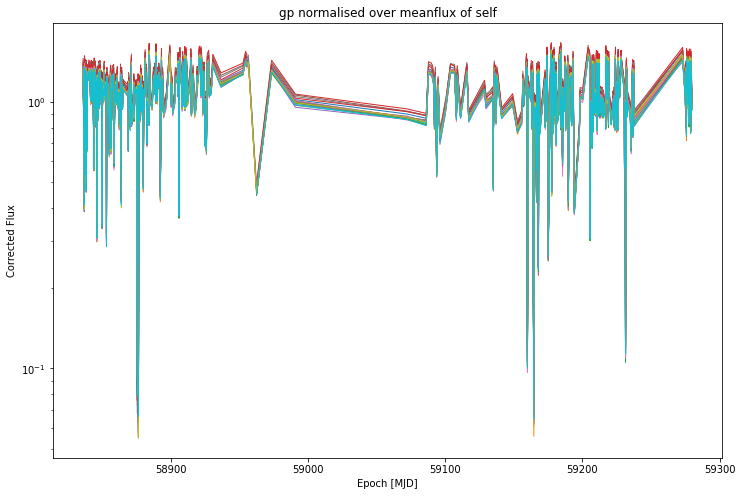

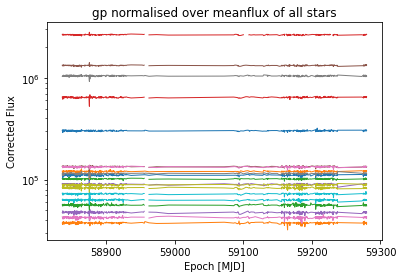

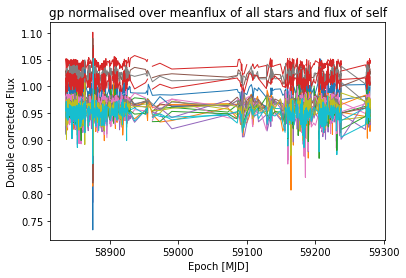

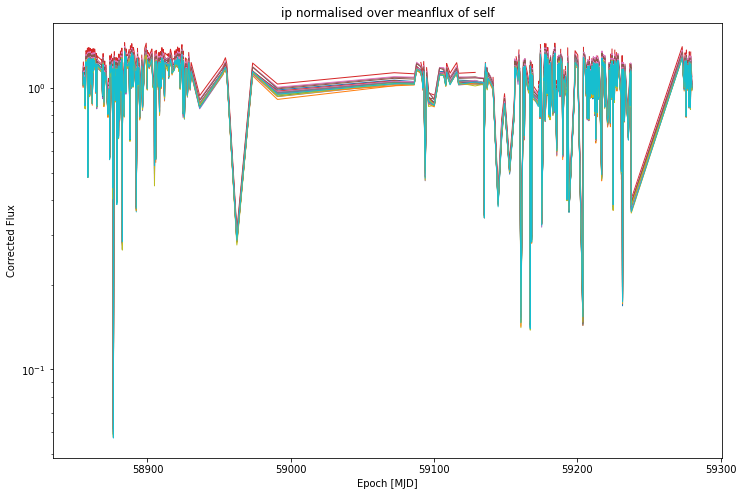

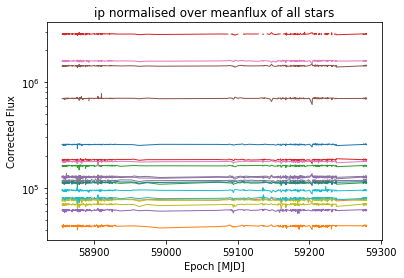

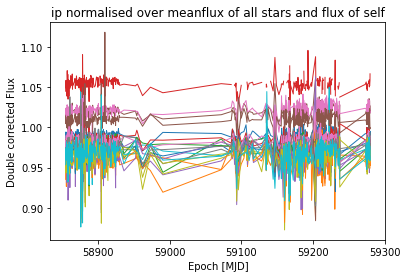

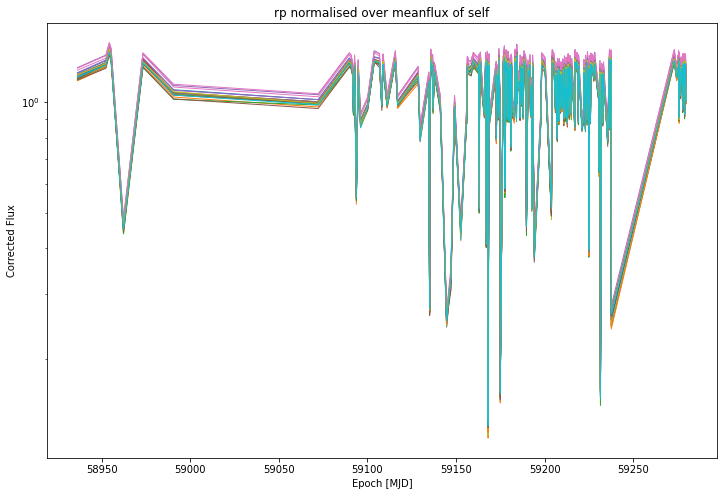

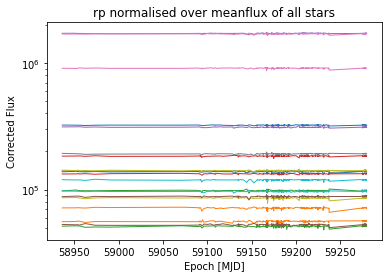

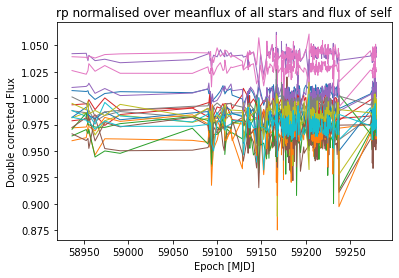

In [21]:
for f in filt:
    plt.figure(figsize=(12,8))
    for i in np.arange(corN_stars[f])[var_mask[f]]:
        plt.plot(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],linewidth=1, label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(12,8))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f],newnormflux[f][:,i],linewidth=1, label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(12,8))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f],newnormflux[f][:,i]/meanflux_star[f][var_mask[f]][i],linewidth=1, label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    #plt.axis(ymin=0.8,ymax=1.1)
    plt.show()  

In [32]:
# Get the star number and coordinates for the selected stars
selecteds = {}
selecteds_coords = {}
standards = ascii.read('standards.txt')
#print (standards)
for f in filt:
    selecteds[f] = np.arange(1,N_stars+1)[smask[f]][var_mask[f]] # Starnr is counting from 1 to 161
    selecteds_coords[f] = standards[smask[f]][var_mask[f]]
    print (selecteds[f])
    print (selecteds_coords[f])

[ 13  20  23  38  49  52  55  57  59  63  65  67  76  77  78  85 115 122
 140 154]
        RA                Dec        
----------------- -------------------
89.97216001608966  -30.99479153579908
89.95929416592625  -30.99858920118258
89.98254160082152  -31.04355033989471
89.95974786989919 -31.047073688463133
90.05091595012878 -31.048362559659676
89.96086403084148 -31.053978641872988
89.93094974126141 -31.010525514237628
 89.9920868133042 -30.945703878287468
90.02605846054601 -31.068767479853655
90.03977517614022  -31.06662633743009
90.03772261486931  -30.94571025456909
89.99908543480656 -30.936377724398042
90.03410296154897  -31.07919849604942
90.08588872900843 -31.038089110369913
89.96570212579576  -31.07802612539779
 90.0675955741275 -31.069619683446863
89.89585502452336 -31.032592314109685
89.91189100519755  -30.94994370770423
89.91341968169606  -30.93968853377502
90.08078424314229  -31.09351132507417
[ 13  20  23  38  49  52  57  59  63  65  67  78  85  89 113 114 115 122
 140 154

In [46]:
# Write out the coordinates of the selected stars to a file
col_content = {}
col_names = {}
for f in filt:
    col_content[f] = []
    #col_content[f].append(selecteds[f])
    col_content[f].append(np.array(selecteds_coords[f]['RA']))
    col_content[f].append(np.array(selecteds_coords[f]['Dec']))
    
    col_names[f] = []
    #col_names[f].append(f+'starnr')
    col_names[f].append('RA')
    col_names[f].append('Dec')
    
print (col_content)
print (col_names)

for f in filt:
    filecontent = Table(col_content[f], names=col_names[f])
    ascii.write(filecontent, 'selecteds_coords_'+f+'.txt', overwrite=True)

tmp = []
for f in filt:
    tmp.append(selecteds[f])
ascii.write(Table(tmp,names=filt), 'selected_stars.txt', overwrite=True)

{'gp': [array([89.97216002, 89.95929417, 89.9825416 , 89.95974787, 90.05091595,
       89.96086403, 89.93094974, 89.99208681, 90.02605846, 90.03977518,
       90.03772261, 89.99908543, 90.03410296, 90.08588873, 89.96570213,
       90.06759557, 89.89585502, 89.91189101, 89.91341968, 90.08078424]), array([-30.99479154, -30.9985892 , -31.04355034, -31.04707369,
       -31.04836256, -31.05397864, -31.01052551, -30.94570388,
       -31.06876748, -31.06662634, -30.94571025, -30.93637772,
       -31.0791985 , -31.03808911, -31.07802613, -31.06961968,
       -31.03259231, -30.94994371, -30.93968853, -31.09351133])], 'ip': [array([89.97216002, 89.95929417, 89.9825416 , 89.95974787, 90.05091595,
       89.96086403, 89.99208681, 90.02605846, 90.03977518, 90.03772261,
       89.99908543, 89.96570213, 90.06759557, 89.94176835, 89.91885243,
       90.08130988, 89.89585502, 89.91189101, 89.91341968, 90.08078424]), array([-30.99479154, -30.9985892 , -31.04355034, -31.04707369,
       -31.04836256, -31